<a href="https://colab.research.google.com/github/Ashish-Tripathy/ComputerVision/blob/master/Asg_5_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architectural Highlights of this Iteration
1. image normalization - Normalising image using mean and standard deviation of all the images in the input
2. L2 regularization
3. ReLU after BN -  I have been implementing ReLU after BN from EIP experience

# **Import Libraries and modules**

In [1]:

import keras

Using TensorFlow backend.


In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist
from matplotlib import pyplot

### Load pre-shuffled MNIST data into train and test sets

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

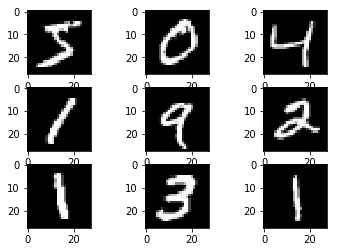

In [4]:
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [14]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [16]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# Image Normalisation
Create an Image generator that standardises data

Statistics train=33.318 (78.567), test=33.791 (79.172)
Data Generator mean=33.318, std=78.567
(60000, 28, 28, 1) -3.4560264e-07 0.9999998


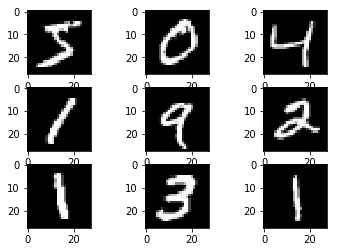

In [7]:
from keras.preprocessing.image import ImageDataGenerator


# report pixel means and standard deviations
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (X_train.mean(), X_train.std(), X_test.mean(), X_test.std()))
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# calculate the mean on the training dataset
datagen.fit(X_train)
print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

#creating batch generators
train_generator = datagen.flow(X_train, Y_train, batch_size=128, shuffle=False)
validation_generator = datagen.flow(X_test, Y_test, batch_size=128, shuffle=False)


# generating standardised data to print the stats
iterator = datagen.flow(X_train, Y_train, batch_size=len(X_train), shuffle=False)

# get a batch
batchX, batchy = iterator.next()
# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())
for X_batch, y_batch in iterator:
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

#### The normalised image is very much similar to the image generated from the original train data above.

# Mounting Google Drive to save the best models

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Building the Architecture

In [10]:
from keras.models import Model
from keras.layers import Input,Conv2D, BatchNormalization,Activation, Flatten
from keras.regularizers import l2

input = Input(shape=(28, 28, 1,))

#defining convolution block
def conv_block(inputs, filters,padding = 'valid'):
  conv = Conv2D(filters = filters, kernel_size = (3,3), padding=padding, use_bias=False, 
                kernel_regularizer = l2(1E-4))(inputs)     #Adding Kernel Regularizer
  conv = Dropout(0.1)(conv)
  conv = BatchNormalization()(conv) # BN before ReLu
  conv = Activation('relu')(conv)
  return conv

#defining transition block
def bottleneck(inputs,filters):
  conv = Conv2D(filters = filters, kernel_size = (1,1), padding = 'valid', use_bias = False)(inputs)
  conv = Dropout(0.1)(conv)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return MaxPooling2D()(conv)

#Building the architecture
First_Layer  =  conv_block(input, 8) #26 RF 3x3
Second_Layer =  conv_block(First_Layer,12) #24 RF 5x5
Third_Layer  =  conv_block(Second_Layer,16) #22 RF 5x5
Transition_1 =  bottleneck(Third_Layer,12) #11 RF 7x7
Fourth_Layer =  conv_block(Transition_1,16) #9 RF 14x14
Fifth_Layer =  conv_block(Fourth_Layer,32)  #7 RF 16x16 
last1x1      =  Conv2D(filters = 10, kernel_size = (1,1), padding = 'valid', use_bias = False)(Fifth_Layer)
last1x1      =  Activation('relu')(last1x1)
last_layer   =  Conv2D(filters = 10, kernel_size = (7,7), padding = 'valid', use_bias = False)(last1x1) #1; RF 22x22
last_layer   =  BatchNormalization()(last_layer)
flatten      =  Flatten()(last_layer)
output       =  Activation('softmax')(flatten)

#creating the model
model = Model(inputs=[input], outputs=[output])
model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 8)         72        
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_9 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 12)        864       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 12)        0         
__________

In [11]:
from keras.callbacks import *

filepath="/content/gdrive/My Drive/Colab Notebooks/Asg5DNNMnist_28thMay:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='auto')

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
callbacks_list = [checkpoint]


TRAIN_STEP_SIZE = np.ceil(train_generator.n/train_generator.batch_size)
VAL_STEP_SIZE = np.ceil(validation_generator.n/validation_generator.batch_size)
model.fit_generator(train_generator, 
                    epochs=40,
                    steps_per_epoch = TRAIN_STEP_SIZE,
                    validation_steps=VAL_STEP_SIZE,
                    validation_data=validation_generator,
                    callbacks = callbacks_list)

Epoch 1/40
469/469 [==============================] - 9s 19ms/step - loss: 0.5792 - acc: 0.9047 - val_loss: 0.2495 - val_acc: 0.9725

Epoch 00001: val_acc improved from -inf to 0.97250, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg5DNNMnist_28thMay:001-val_acc:0.973.hdf5
Epoch 2/40
469/469 [==============================] - 7s 15ms/step - loss: 0.2278 - acc: 0.9738 - val_loss: 0.1275 - val_acc: 0.9840

Epoch 00002: val_acc improved from 0.97250 to 0.98400, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg5DNNMnist_28thMay:002-val_acc:0.984.hdf5
Epoch 3/40
469/469 [==============================] - 7s 16ms/step - loss: 0.1467 - acc: 0.9812 - val_loss: 0.0916 - val_acc: 0.9881

Epoch 00003: val_acc improved from 0.98400 to 0.98810, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg5DNNMnist_28thMay:003-val_acc:0.988.hdf5
Epoch 4/40
469/469 [==============================] - 8s 17ms/step - loss: 0.1084 - acc: 0.9845 - val_loss: 0.0740 - val_acc: 0.9891


# Predicting using the Best Model

In [33]:
from keras.models import load_model
modelPath = '/content/gdrive/My Drive/Colab Notebooks/Asg5DNNMnist_28thMay:035-val_acc:0.994.hdf5'
model = load_model(modelPath)

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([7, 2, 5, ..., 4, 5, 6])

### Confusion Matrix

In [34]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[ 838,    0,   87,    0,   16,    0,   33,    0,    0,    6],
       [   3,   31,  674,    0,  245,   92,   23,    0,    4,   63],
       [   0,    0, 1020,    0,   10,    0,    0,    0,    0,    2],
       [  10,    0,  152,  740,   26,   40,   25,    6,    1,   10],
       [   0,    0,    1,    0,  946,    0,    0,    0,    0,   35],
       [   0,    0,   16,    0,   41,  738,   54,    0,    0,   43],
       [   7,    0,    4,    0,   38,    1,  908,    0,    0,    0],
       [   0,    0,  213,    0,   31,    7,    1,  746,    1,   29],
       [   2,    0,  214,    0,   69,    0,   40,    0,  591,   58],
       [   0,    0,   10,    0,    4,    6,    1,    1,    0,  987]])

In [0]:
import pandas as pd
d = {'pred': y_pred, 'true': y_test} #axis=1!important!
df = pd.DataFrame(data=d)

In [37]:
df.head()

,pred,true
0,7,7
1,2,2
2,5,1
3,0,0
4,4,4


# Disolaying the Misclassified Images

In [0]:
misclassified = []
for i in range(len(y_test)):
  if(y_test[i]!=y_pred[i]):
    misclassified.append(i)
    if len(misclassified)==26:
      break


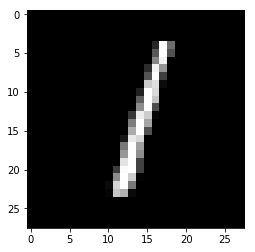

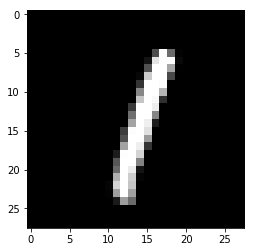

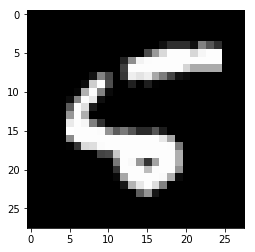

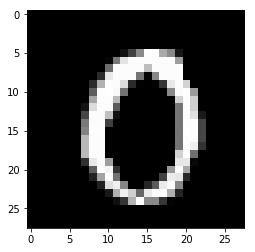

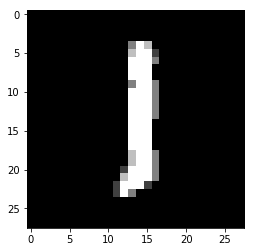

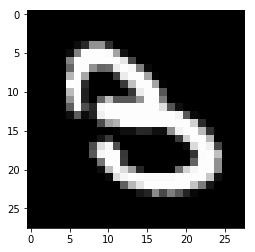

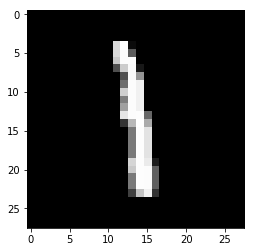

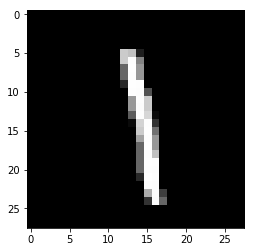

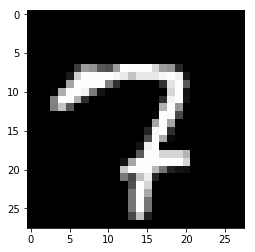

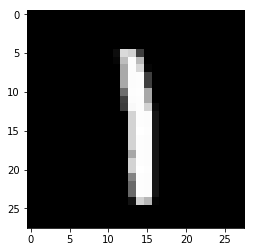

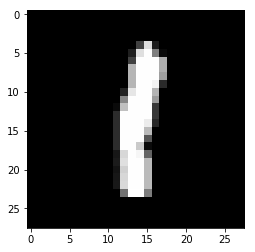

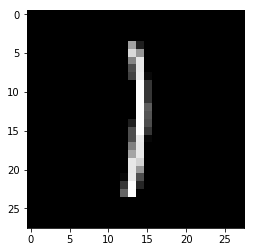

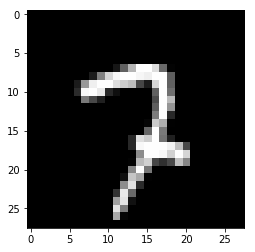

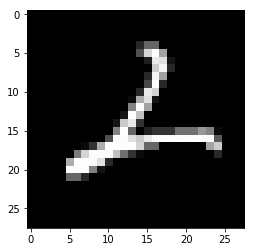

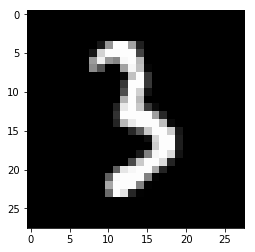

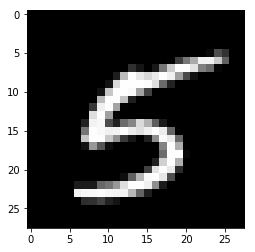

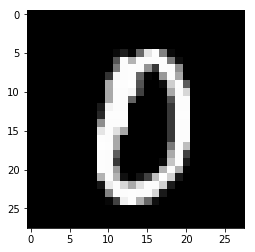

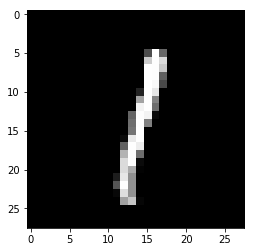

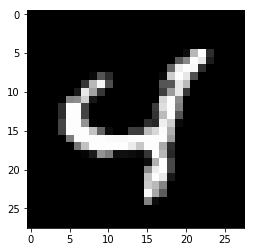

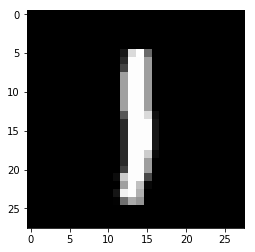

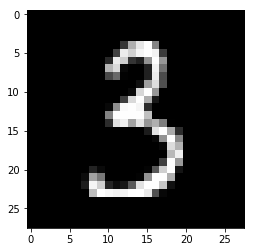

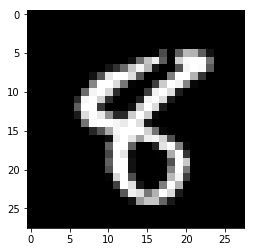

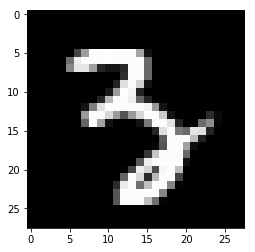

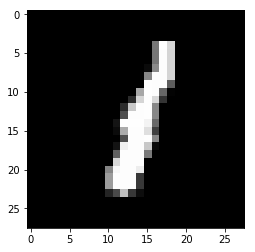

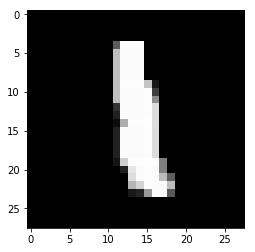

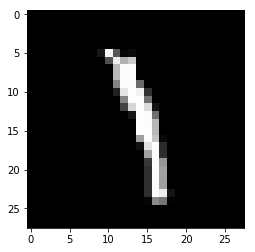

In [135]:
for i in range(26):
  index = misclassified[i]
  pyplot.imshow(X_test[index].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
  pyplot.show()


# Downloading the Images

In [0]:
from google.colab import files
for i in range(26):
  image = 'misclass_'+str(misclassified[i])+'.png'
  pyplot.imsave(image,X_test[misclassified[i]].reshape(28, 28))
  files.download(image)
    